<font size="4"> D602 Task 2: Data Production Pipeline </font>

In [53]:
# Import Packages
import datetime
import pandas as pd
import argparse
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder, OneHotEncoder
from sklearn import metrics, linear_model
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
import mlflow
import mlflow.sklearn
import logging
import os
import pickle
import json

<font size="4"> B: Import and Format Script </font>

Import

In [54]:
#Import Data
airport=pd.read_csv('/Users/elineiman/Desktop/WGU Data Sets/T_ONTIME_REPORTING.csv')

Format

In [55]:
#Rename columns
airport.rename(columns={
    'DAY_OF_MONTH': 'DAY',
    'ORIGIN': 'ORG_AIRPORT',
    'DEST_AIRPORT_ID':'DEST_AIRPORT',
    'CRS_DEP_TIME': 'SCHEDULED_DEPARTURE',
    'DEP_TIME': 'DEPARTURE_TIME',
    'DEP_DELAY': 'DEPARTURE_DELAY',
    'CRS_ARR_TIME': 'SCHEDULED_ARRIVAL',
    'ARR_TIME': 'ARRIVAL_TIME',
    'ARR_DELAY': 'ARRIVAL_DELAY'
}, inplace=True)

#drop columns
airport.drop('ORIGIN_AIRPORT_ID', axis=1, inplace=True)
airport.drop('DEST_CITY_NAME', axis=1, inplace=True)

In [56]:
#Confirm format matches the project requirement outlined in poly_regressor
airport.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,ORG_AIRPORT,DEST_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,2024,1,1,1,ABE,10397,600,558.0,-2.0,832,757.0,-35.0
1,2024,1,1,1,ABE,10397,1231,1240.0,9.0,1450,1437.0,-13.0
2,2024,1,1,1,ABE,11057,600,558.0,-2.0,803,758.0,-5.0
3,2024,1,1,1,ABE,11057,1158,1442.0,164.0,1357,1620.0,143.0
4,2024,1,1,1,ABE,11057,1713,1700.0,-13.0,1912,1839.0,-33.0


DVC Command

Create the Metafile

In [57]:
#DVC Command 
#airport.to_csv('temp.csv', index=False)

In [58]:
#!dvc add temp.csv

Push and Commit to GitLab

In [59]:
#verify file creation
#!ls -la

In [60]:
#Commit the Metafile
#!git commit -m "DVC Metafile"

In [61]:
#Push the Metafile
#!git push origin main

<font size="4"> C: data Filtering Script </font>

Filter all airports to LAX

In [62]:
airport.shape

(547271, 12)

In [63]:
lax=airport[airport['ORG_AIRPORT'] == "LAX"]
lax.shape

(15228, 12)

Data Cleaning

In [64]:
#Check for Null values
lax.isnull().sum()

YEAR                     0
MONTH                    0
DAY                      0
DAY_OF_WEEK              0
ORG_AIRPORT              0
DEST_AIRPORT             0
SCHEDULED_DEPARTURE      0
DEPARTURE_TIME         464
DEPARTURE_DELAY        464
SCHEDULED_ARRIVAL        0
ARRIVAL_TIME           491
ARRIVAL_DELAY          517
dtype: int64

In [65]:
#Departure and arrival time have about 500 null values, respectively. Dropping the null values
#15,228 rows prior to drops
lax.dropna(inplace=True)
lax.shape

/var/folders/d3/xxdfzd3n6lq70gynyy5khm800000gn/T/ipykernel_82866/3990229517.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lax.dropna(inplace=True)


(14711, 12)

In [66]:
#Examine Data Types
print(lax.dtypes)

YEAR                     int64
MONTH                    int64
DAY                      int64
DAY_OF_WEEK              int64
ORG_AIRPORT             object
DEST_AIRPORT             int64
SCHEDULED_DEPARTURE      int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
SCHEDULED_ARRIVAL        int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
dtype: object


In [67]:
#Change data types
lax['DEST_AIRPORT'] = lax['DEST_AIRPORT'].astype(str)
lax['DEPARTURE_TIME'] = lax['DEPARTURE_TIME'].astype(int)
lax['DEPARTURE_DELAY'] = lax['DEPARTURE_DELAY'].astype(int)
lax['ARRIVAL_TIME'] = lax['ARRIVAL_TIME'].astype(int)
lax['ARRIVAL_DELAY'] = lax['ARRIVAL_DELAY'].astype(int)

/var/folders/d3/xxdfzd3n6lq70gynyy5khm800000gn/T/ipykernel_82866/1639835465.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lax['DEST_AIRPORT'] = lax['DEST_AIRPORT'].astype(str)
/var/folders/d3/xxdfzd3n6lq70gynyy5khm800000gn/T/ipykernel_82866/1639835465.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lax['DEPARTURE_TIME'] = lax['DEPARTURE_TIME'].astype(int)
/var/folders/d3/xxdfzd3n6lq70gynyy5khm800000gn/T/ipykernel_82866/1639835465.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [68]:
#Output cleaned data
#lax.to_csv('lax_airport_data', index=False) 

<font size="4"> D: MLFlow Experiment </font>

Set Up

In [69]:
#Set Alphas
num_alphas=20
#Set Order
order=3

In [70]:
# read the data file
df = pd.read_csv('/Users/elineiman/GIT/d602-deployment-task-2/MLProject/Data/lax_airport_data')
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})

In [71]:
#Extract flight dates
def grab_month_year(df:pd.DataFrame) -> tuple:
    """
    grab_month_year is a function to extract the month and year of the flights in the departure delay dataset.

    Parameters
    ----------
    df : pd.DataFrame
        the input data set in Pandas data frame format.

    Returns
    -------
    tuple
        (month,year) of the data set.

    Raises
    ------
    Exception
        If more than one month or year are found in the data set.
    """
    months = pd.unique(df['MONTH'])
    years = pd.unique(df['YEAR'])
    if len(months) >1:
        raise Exception("Multiple months found in data set, only one acceptable")
    else:
        month = int(months[0])
    if len(years) > 1:
        raise Exception("Multiple years found in data set, only one acceptable")
    else:
        year = int(years[0])
    return (month, year)

In [72]:
#Convert to Datetime
def format_hour(string: str) -> datetime:
    """
    format_hour is a function to convert an 'HHMM' string input to a time in datetime format.

    Parameters
    ----------
    string : string
        An hour and minute in 'HHMM' format.

    Returns
    -------
    datetime
        An hour and minute (datetime.time).  Returns nan if input string is null.

    """    
    if pd.isnull(string):
        return np.nan
    else:
        if string == 2400: string = 0
        string = "{0:04d}".format(int(string))
        hour = datetime.time(int(string[0:2]), int(string[2:4]))
        return hour

def combine_date_hour(x: list) -> datetime:
    """
    combine_date_hour is a function that combines a date and time to produce a datetime.datetime

    Parameters
    ----------
    x : list
        A list containing a date and a time in datetime format.

    Returns
    -------
    datetime
        A combined date and time in datetime format. Returns nan if time is null.

    """
    if pd.isnull(x.iloc[0]) or pd.isnull(x.iloc[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x.iloc[0],x.iloc[1])


def create_flight_time(df: pd.DataFrame, col: str) -> pd.Series:
    """
    create_flight_time is a function that combines two columns of a data frame to produce a datetime.datetime series.

    Parameters
    ----------
    df : pd.DataFrame
        A data frame containing flight departure delay data
    col: string
        The name of one of the columns in the data frame containing flight departure delay data

    Returns
    -------
    pd.Series
        A Pandas series of datetimes with combined date and time

    """
    list = []
    for index, cols in df[['DATE', col]].iterrows():
        if pd.isnull(cols.iloc[1]):
            list.append(np.nan)
        elif float(cols.iloc[1]) == 2400:
            cols.iloc[0] += datetime.timedelta(days=1)
            cols.iloc[1] = datetime.time(0,0)
            list.append(combine_date_hour(cols))
        else:
            cols.iloc[1] = format_hour(cols.iloc[1])
            list.append(combine_date_hour(cols))
    return pd.Series(list)

In [73]:
#Change Format
def create_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    create_df is a function that wrangles data within a flight departure delay data frame into the format needed for ML training.

    Parameters
    ----------
    df : pd.DataFrame
        A data frame containing flight departure delay data

    Returns
    -------
    pd.DataFrame
        A Pandas data frame with modified columns and data formats suitable for regression model training

    """
    df2 = df[['SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
                                    'DEST_AIRPORT','DEPARTURE_DELAY']]
    df2 = df2.dropna(how = 'any')
    df2.loc[:,'weekday'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.weekday())
    #____________________
    # delete delays > 1h
    df2.loc[:,'DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
    df2 = df2.dropna(how = 'any')
    #_________________
    # formating times
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    df2.loc[:,'hour_depart'] = df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    df2.loc[:,'hour_depart'] = df2['hour_depart'].apply(fct)
    df2.loc[:,'hour_arrive'] = df2['SCHEDULED_ARRIVAL'].apply(fct)
    df2 = df2[['hour_depart','hour_arrive',
            'DEST_AIRPORT','DEPARTURE_DELAY','weekday']]
    df3 = df2.groupby(['hour_depart', 'hour_arrive', 'DEST_AIRPORT'],
                      as_index = False).mean()
    return df3

In [74]:
#Change Format
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])
(month,year) = grab_month_year(df)
#logging.info("Month and year of data: %s %s", month, year)
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_hour)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_hour)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_hour)

In [75]:
# define training data as the first 3 weeks of the month, and test data as that from the fourth week of the month
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(year, month, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(year, month, 23)]

In [76]:
 #Training Data Frame
df3 = create_df(df_train)

In [77]:
# perform one-hot encoding of all destination airports in training data
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(df3['DEST_AIRPORT'])
#_________________________________________________________
zipped = zip(integer_encoded, df3['DEST_AIRPORT'])
label_airports = list(set(list(zipped)))
label_airports.sort(key = lambda x:x[0])
#_________________________________________________
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#_________________________________________________
b = np.array(df3[['hour_depart', 'hour_arrive']])
X = np.hstack((onehot_encoded, b))
Y = np.array(df3['DEPARTURE_DELAY'])
Y = Y.reshape(len(Y), 1)
#logging.info("Airport one-hot encoding successful")

In [78]:
# train/validation split at 30%
X_train, X_validate, Y_train, Y_validate = train_test_split(X, Y, test_size=0.3)

In [79]:
#Define Experiment
nowdate = datetime.date.today()
# creates an experiment name that changes every day
experiment_name = "Airport Departure Delays" + str(nowdate)
# creates new experiment if there is not one yet today, otherwise sets the experiment to the existing one for today
experiment = mlflow.set_experiment(experiment_name)
run_name = "Run started at " + datetime.datetime.now().strftime("%H:%M")

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 327, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 421, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1367, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1360, in _read_helper
    result = read_yaml(root, file_name)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/ana

In [81]:
#Run Experiment
with mlflow.start_run(experiment_id = experiment.experiment_id, run_name=run_name):
    score_min = 10000
    alpha_max = num_alphas * 2
    count = 1
    # loop through all alpha values
    for alpha in range(0, alpha_max, 2):
        run_num = "Training Run Number " + str(count)
        # create a Ridge regressor with the stated alpha
        ridgereg = Ridge(alpha = alpha/10)
        # create polynomial features based on the polyniomial order
        poly = PolynomialFeatures(degree=order)
        # fit the model using the training data
        X_ = poly.fit_transform(X_train)
        ridgereg.fit(X_, Y_train)
        X_ = poly.fit_transform(X_validate)
        # predict against the validation data
        result = ridgereg.predict(X_)
        # how well did the model do when compared to the validation actuals?
        score = metrics.mean_squared_error(result, Y_validate)
        with mlflow.start_run(run_name = run_num,nested=True):
            mlflow.log_param("alpha",alpha/10)
            mlflow.log_param("order", order)
            mlflow.log_metric("Training Data Mean Squared Error",score)
            mlflow.log_metric("Training Data Average Delay",np.sqrt(score))
        if score < score_min:
            score_min = score
            parameters = [alpha, order]
        #logging.info("n={} alpha={} , MSE = {:<0.5}".format(order, alpha/10, score))
        count +=1
    # train and predict on validation data with optimal alpha found
    X_ = poly.fit_transform(X_validate)
    tresult = ridgereg.predict(X_)
    tscore = metrics.mean_squared_error(tresult, Y_validate)
    #logging.info('Training Data Final MSE = {}'.format(round(tscore, 2)))
    mlflow.log_metric("Training Data Mean Squared Error",tscore)
    mlflow.log_metric("Training Data Average Delay",np.sqrt(tscore))
    mlflow.log_param("alpha",alpha/10)
    mlflow.log_param("order", order)
    #logging.info("Successfully Logged Parameters:")

    run_id = mlflow.active_run().info.run_id
    logged_params = mlflow.get_run(run_id).data.params
    #logging.info("Successfully Logged Parameters:")
    #for key, value in logged_params.items():
        #logging.info(f"{key}: {value}") 

mlflow.end_run()
#logging.info("Model training loop completed with %s iterations", count-1)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/lin

In [82]:
# create a data frame of the test data
df3 = create_df(df_test)

label_conversion = dict()
for s in label_airports:
    label_conversion[s[1]] = int(s[0])

# export airport label conversion for test data to json file for later use
jsonout = json.dumps(label_conversion)
f = open("airport_encodings.json","w")

# write json object to file
f.write(jsonout)

# close file
f.close()
#logging.info("Export of airport one-hot encoding successful")
df3.loc[:,'DEST_AIRPORT'] = df3.loc[:,'DEST_AIRPORT'].map(pd.Series(label_conversion))

# manually one-hot encode destination airports for test data
for index, label in label_airports:
    temp = df3['DEST_AIRPORT'] == index
    temp = temp.apply(lambda x:1.0 if x else 0.0)
    if index == 0:
        matrix = np.array(temp)
    else:
        matrix = np.vstack((matrix, temp))
matrix = matrix.T

b = np.array(df3[['hour_depart', 'hour_arrive']])
X_test = np.hstack((matrix, b))
Y_test = np.array(df3['DEPARTURE_DELAY'])
Y_test = Y_test.reshape(len(Y_test), 1)
#logging.info("Wrangling of test data successful")

In [83]:
# create polynomial features based on order
X_ = poly.fit_transform(X_test)
# predict on last week of month data
result = ridgereg.predict(X_)
score = metrics.mean_squared_error(result, Y_test)
#logging.info('Test Data MSE = {}'.format(round(score, 2)))
#logging.info("Predictions using test data successful")
#logging.info('Test Data average delay = {:.2f} min'.format(np.sqrt(score))) 

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


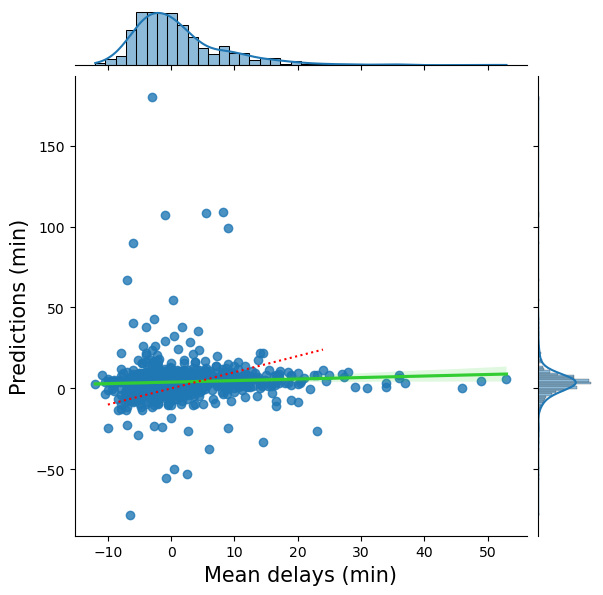

In [84]:
# create and export model performance plot
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in result[:,0]]) 
tips["original_data"] = pd.Series([float(s) for s in Y[:,0]]) 
sns.jointplot(x="original_data", y="prediction", data=tips, height = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')
plt.savefig("model_performance_test.jpg",dpi=300)
#logging.info("Model performance plot export successful")